# Semester 4 Coding Portfolio Topic 1 Summative:
# Regularisation for Regression Models

In this notebook, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [2]:
# TODO: Please enter your student number here
STUDENT_NUMBER = 15120139

# SUMMATIVE ASSESSMENT

For this summative assignment, we ask you to find a dataset from an internet source of choice.

The general assessment criteria for all summative assignments are mentioned in the assignment description on Canvas. Each notebook also has a few specific criteria we look for; make sure you fulfil them in your approach to this assignment.
In general, make sure this notebook represents a complete project: Write an explanation of what you are hoping to achieve with your analysis, document your code well, and present results in a comprehensive way.

# Assessment Criteria
 - A suitable dataset for regression is selected, and a reasonable argument is made for why regularization is expected to be valuable for its analysis.
 - A regularization and a model-selection method (e.g., Ridge, Lasso, or Elastic Net) is correctly implemented, including hyperparameter tuning and a baseline comparison.
 - Appropriate performance metrics and visualizations (e.g., coefficient paths, error plots) are provided and interpreted clearly.
 - The notebook contains thoughtful reflection on the models performances, discussing limitations, bias-variance trade-offs, or improvements over a baseline approach.

You should choose a dataset for which you have no prior knowledge of the underlying data generating process (i.e. if you're an expert in election, do not pick an elections dataset -- aim to learn something totally new). Ensure the dataset is moderately sized, but has a very large number of features, such that multicollinearity is likely present and regularisation is necessary.  

Using BOTH model regularisation and model selection, show how penalised regression models can be used to learn about the distribution of the effect of useful features, and generate accurate predictions for the target of interest. 

Now pick a dataset of your choice. Please ensure your dataset is a csv file under 50MB named sem4_topic1_summative_data.csv

In [3]:
# Do NOT modify the contents of this cell. Start your customization in the next one!
import pandas as pd

custom_data_path = "sem4_topic1_summative_data.csv"
custom_df = pd.read_csv(custom_data_path)

FileNotFoundError: [Errno 2] No such file or directory: 'sem4_topic1_summative_data.csv'

In [ ]:
# Feel free to add any code or markdown cells between here and the final code cell, and fill them with your custom analysis!




About:
- I took two datasets that describe active ingredients and components in wines (red and white) from the north of Portugal. My objective is to model wine quality based on physicochemical tests.

- These two datasets are based on red and white variants of the Portuguese "Vinho Verde" wine (http://www.vinhoverde.pt/en/). Unfortunately, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

- We can definitely do regression or classifiation tasks on these two datasets; The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). We could use outlier detections algorythms since they could be useful to detect the few excellent or bad wines

Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

## pupa hey

# Wine Quality Prediction with Regularised Regression

## Overview

This notebook predicts the **quality score** (0–10) of Portuguese *Vinho Verde* wines
from physicochemical measurements, using the
[UCI Wine Quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality).
We combine red and white wine samples and engineer polynomial interaction features,
creating a high-dimensional, multicollinear feature space where regularisation is
expected to outperform OLS.

**Why regularisation?**
- Several features are chemically related (e.g., `free sulfur dioxide` ↔ `total sulfur dioxide`, `alcohol` ↔ `density`)
  introducing multicollinearity that inflates OLS variance.
- After polynomial expansion the feature count exceeds 90, with $n \approx 6500$ — a
  moderate ratio that invites overfitting without a penalty term.

**Models compared:** OLS baseline · Ridge · Lasso · Elastic Net  
**Selection method:** cross-validated hyperparameter search for all regularised models


## 1 · Imports & Data Loading

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import (
    LinearRegression, RidgeCV, Ridge,
    LassoCV, Lasso, ElasticNetCV, ElasticNet
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.utils import resample

plt.rcParams['figure.dpi'] = 110
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
print("Imports OK")

Imports OK


In [5]:
# Combine red and white Vinho Verde wine samples; add binary wine-type indicator
url_red   = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

red   = pd.read_csv(url_red,   sep=';'); red['is_red']   = 1
white = pd.read_csv(url_white, sep=';'); white['is_red'] = 0
df = pd.concat([red, white], ignore_index=True)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


## 2 · Exploratory Data Analysis

In [6]:
# Quality distribution and missing values
print("Missing values:", df.isnull().sum().sum())
print("Quality value counts:")
print(df['quality'].value_counts().sort_index())

Missing values: 0
Quality value counts:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


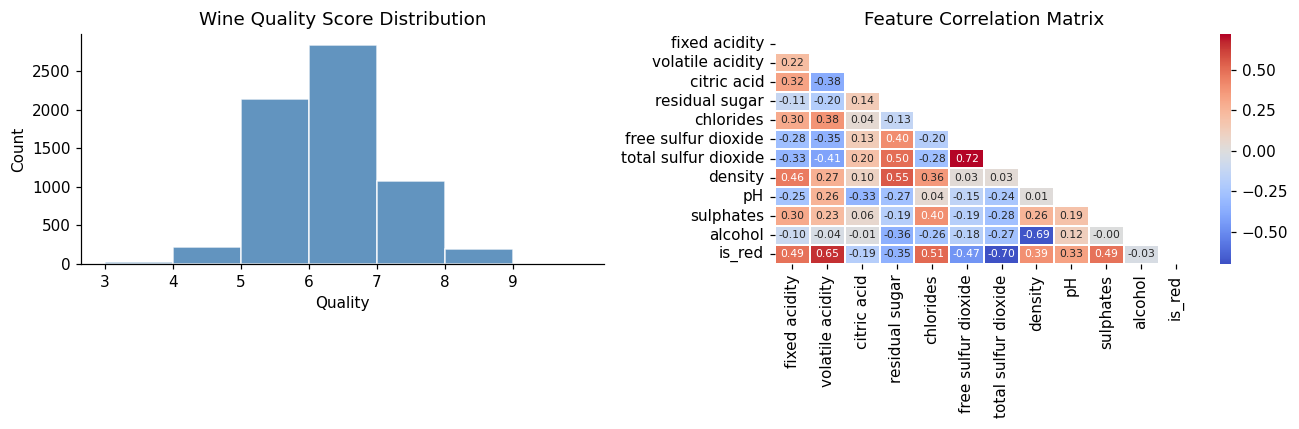


High-correlation pairs (|r| > 0.60):
  free sulfur dioxide            <-> total sulfur dioxide            r = +0.721
  alcohol                        <-> density                         r = -0.687
  is_red                         <-> volatile acidity                r = +0.653
  is_red                         <-> total sulfur dioxide            r = -0.700


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Target distribution
axes[0].hist(df['quality'], bins=range(3, 11), edgecolor='white', color='steelblue', alpha=0.85)
axes[0].set(title='Wine Quality Score Distribution', xlabel='Quality', ylabel='Count')
axes[0].set_xticks(range(3, 10))

# Correlation heatmap — reveals multicollinearity between features
corr = df.drop(columns='quality').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.3, ax=axes[1], annot_kws={'size': 7})
axes[1].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

# Print notably correlated pairs
print("\nHigh-correlation pairs (|r| > 0.60):")
for c1 in corr.columns:
    for c2 in corr.columns:
        if c1 < c2 and abs(corr.loc[c1,c2]) > 0.60:
            print(f"  {c1:30s} <-> {c2:30s}  r = {corr.loc[c1,c2]:+.3f}")

## 3 · Feature Engineering

We expand the 12 raw features to degree-2 polynomials and interactions (~90 features).
This makes multicollinearity severe and regularisation genuinely necessary.
Features are standardised **after** the train/test split to prevent data leakage.

In [8]:
X_raw = df.drop(columns='quality').values
y     = df['quality'].values.astype(float)
feat_names_raw = df.drop(columns='quality').columns.tolist()

# Degree-2 expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_raw)
feat_names = poly.get_feature_names_out(feat_names_raw)

# Remove zero-variance columns
var_mask   = np.var(X_poly, axis=0) > 0
X_poly     = X_poly[:, var_mask]
feat_names = feat_names[var_mask]

print(f"Raw features:      {X_raw.shape[1]}")
print(f"Expanded features: {X_poly.shape[1]}")
print(f"Observations:      {X_poly.shape[0]}")

Raw features:      12
Expanded features: 90
Observations:      6497


In [9]:
# Train/test split then scale — fitting scaler only on training data
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.20, random_state=42
)

scaler      = StandardScaler()
X_train_sc  = scaler.fit_transform(X_train)
X_test_sc   = scaler.transform(X_test)

print(f"Train: {X_train_sc.shape}  |  Test: {X_test_sc.shape}")

Train: (5197, 90)  |  Test: (1300, 90)


## 4 · Model Fitting & Hyperparameter Tuning

All regularised models minimise:
$$\hat{\beta} = \arg\min_\beta \|y - X\beta\|_2^2 + \alpha\left[\rho\|\beta\|_1 + \frac{1-\rho}{2}\|\beta\|_2^2\right]$$

$\rho=0$ → Ridge, $\rho=1$ → Lasso, $0<\rho<1$ → Elastic Net.
`alpha` (and `l1_ratio` for Elastic Net) are selected via cross-validation.

In [10]:
# OLS baseline — no penalty; expected to overfit with 90+ correlated features
X_tr_const = sm.add_constant(X_train_sc)
X_te_const = sm.add_constant(X_test_sc)

ols_model = sm.OLS(y_train, X_tr_const).fit()
ols_pred  = ols_model.predict(X_te_const)

print(f"OLS  | RMSE: {np.sqrt(mean_squared_error(y_test, ols_pred)):.4f}  "
      f"R²: {r2_score(y_test, ols_pred):.4f}")

OLS  | RMSE: 0.7555  R²: 0.2271


In [11]:
# Ridge — L2 penalty; stabilises estimation under multicollinearity
alphas_ridge = np.logspace(-4, 5, 300)
ridge_cv = RidgeCV(alphas=alphas_ridge, fit_intercept=True, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_sc, y_train)

ridge_model = Ridge(alpha=ridge_cv.alpha_, fit_intercept=True)
ridge_model.fit(X_train_sc, y_train)
ridge_pred  = ridge_model.predict(X_test_sc)

print(f"Ridge optimal alpha: {ridge_cv.alpha_:.4f}")
print(f"Ridge| RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred)):.4f}  "
      f"R²: {r2_score(y_test, ridge_pred):.4f}")

Ridge optimal alpha: 0.0013
Ridge| RMSE: 0.7582  R²: 0.2215


In [12]:
# Lasso — L1 penalty; sets irrelevant coefficients to exactly 0 (feature selection)
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 200), cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_sc, y_train)

lasso_model = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_model.fit(X_train_sc, y_train)
lasso_pred  = lasso_model.predict(X_test_sc)
n_nz_lasso  = int(np.sum(lasso_model.coef_ != 0))

print(f"Lasso optimal alpha: {lasso_cv.alpha_:.6f}")
print(f"Lasso| RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred)):.4f}  "
      f"R²: {r2_score(y_test, lasso_pred):.4f}  "
      f"Non-zero coefs: {n_nz_lasso}/{len(lasso_model.coef_)}")

Lasso optimal alpha: 0.002866
Lasso| RMSE: 0.7596  R²: 0.2187  Non-zero coefs: 28/90


In [13]:
# Elastic Net — blends L1 and L2; handles correlated features better than pure Lasso
enet_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0],
    alphas=np.logspace(-4, 2, 100),
    cv=5, max_iter=10000, random_state=42
)
enet_cv.fit(X_train_sc, y_train)

enet_model = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=10000)
enet_model.fit(X_train_sc, y_train)
enet_pred  = enet_model.predict(X_test_sc)
n_nz_enet  = int(np.sum(enet_model.coef_ != 0))

print(f"ENet optimal alpha: {enet_cv.alpha_:.6f}  l1_ratio: {enet_cv.l1_ratio_:.2f}")
print(f"ENet | RMSE: {np.sqrt(mean_squared_error(y_test, enet_pred)):.4f}  "
      f"R²: {r2_score(y_test, enet_pred):.4f}  "
      f"Non-zero coefs: {n_nz_enet}/{len(enet_model.coef_)}")

ENet optimal alpha: 0.002848  l1_ratio: 1.00
ENet | RMSE: 0.7597  R²: 0.2185  Non-zero coefs: 28/90


Note: CV selected l1_ratio=1.0, meaning Elastic Net collapsed to pure Lasso.
This suggests L1 regularisation alone is sufficient for this dataset —
the L2 component of Elastic Net adds no benefit here.

## 5 · Performance Comparison

In [14]:
# Summary table
results = pd.DataFrame({
    'Model':         ['OLS (baseline)', 'Ridge', 'Lasso', 'Elastic Net'],
    'Test RMSE':     [np.sqrt(mean_squared_error(y_test, p))
                      for p in [ols_pred, ridge_pred, lasso_pred, enet_pred]],
    'Test R²':       [r2_score(y_test, p)
                      for p in [ols_pred, ridge_pred, lasso_pred, enet_pred]],
    'Features used': [X_train_sc.shape[1], X_train_sc.shape[1], n_nz_lasso, n_nz_enet]
}).sort_values('Test RMSE').reset_index(drop=True)

print(results.to_string(index=False))

         Model  Test RMSE  Test R²  Features used
OLS (baseline)   0.755507 0.227144             90
         Ridge   0.758249 0.221523             90
         Lasso   0.759609 0.218728             28
   Elastic Net   0.759716 0.218508             28


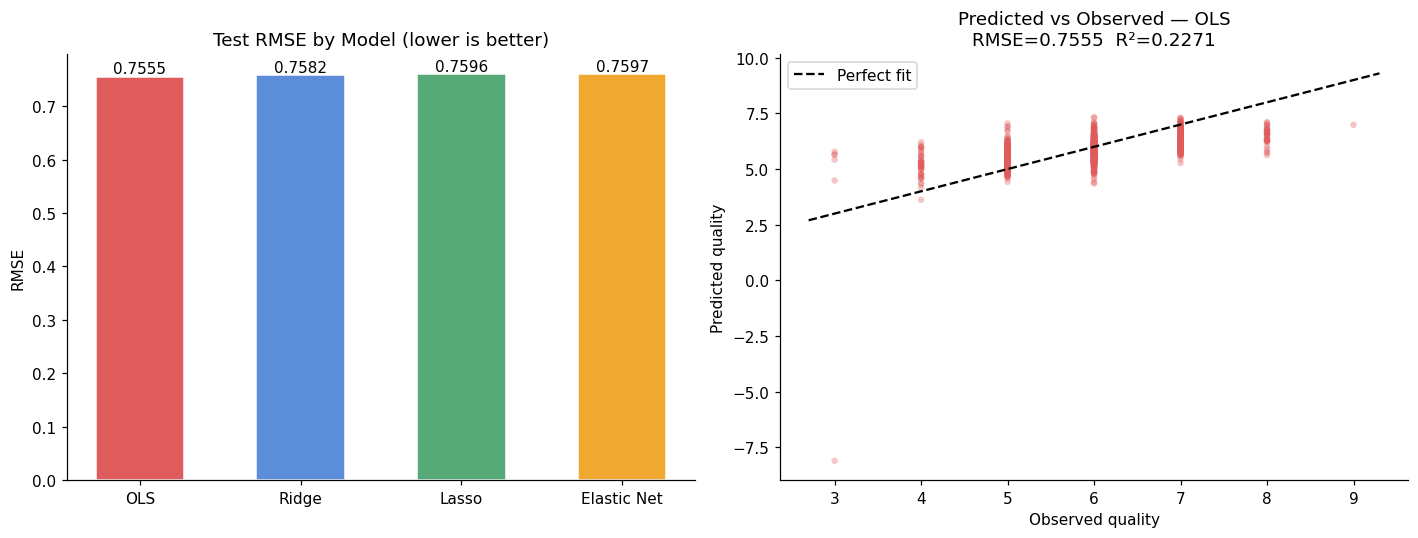

In [15]:
# Visual comparison: RMSE bar chart + predicted vs observed (best model)
all_preds  = [ols_pred, ridge_pred, lasso_pred, enet_pred]
labels     = ['OLS', 'Ridge', 'Lasso', 'Elastic Net']
colors     = ['#e05c5c', '#5b8dd9', '#55aa77', '#f0a830']
rmses      = [np.sqrt(mean_squared_error(y_test, p)) for p in all_preds]

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# RMSE bar chart
bars = axes[0].bar(labels, rmses, color=colors, edgecolor='white', width=0.55)
axes[0].set_title('Test RMSE by Model (lower is better)', fontsize=12)
axes[0].set_ylabel('RMSE')
for b, v in zip(bars, rmses):
    axes[0].text(b.get_x() + b.get_width()/2, v + 0.001, f'{v:.4f}',
                 ha='center', va='bottom', fontsize=10)

# Predicted vs observed for best model
best_idx  = int(np.argmin(rmses))
best_pred = all_preds[best_idx]
axes[1].scatter(y_test, best_pred, alpha=0.35, s=18, color=colors[best_idx], edgecolors='none')
lo, hi = y_test.min()-0.3, y_test.max()+0.3
axes[1].plot([lo,hi],[lo,hi], 'k--', lw=1.5, label='Perfect fit')
axes[1].set_title(f'Predicted vs Observed — {labels[best_idx]}\n'
                  f'RMSE={rmses[best_idx]:.4f}  R²={r2_score(y_test,best_pred):.4f}', fontsize=12)
axes[1].set_xlabel('Observed quality'); axes[1].set_ylabel('Predicted quality')
axes[1].legend()

plt.tight_layout(); plt.show()

## 6 · Coefficient Paths & Feature Selection

Coefficient paths show how each feature's weight changes as regularisation strength
increases. Ridge smoothly shrinks all coefficients; Lasso drives many to exactly zero.

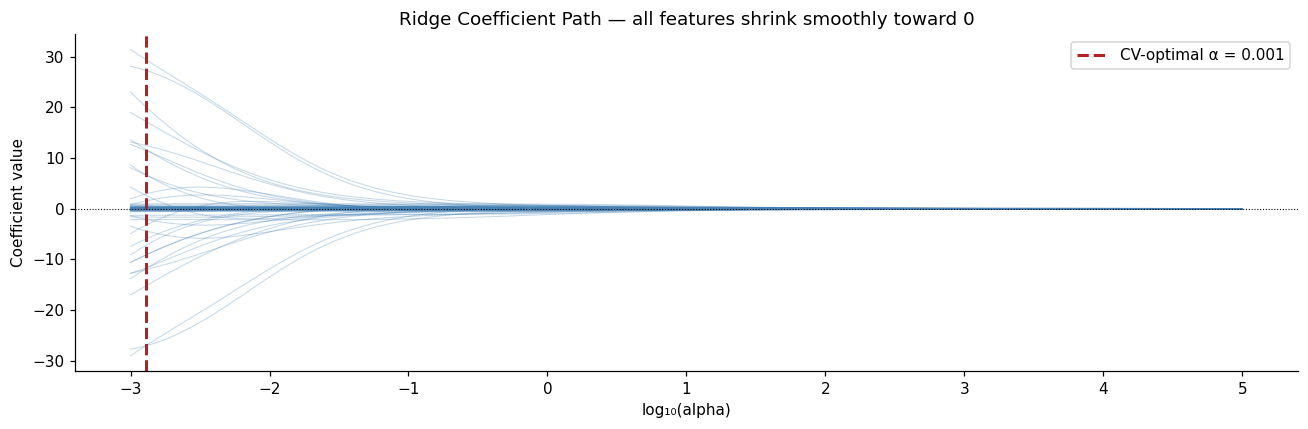

In [16]:
# Ridge path — smooth shrinkage, no exact zeros
alphas_path    = np.logspace(-3, 5, 120)
ridge_coef_path = np.array([
    Ridge(alpha=a).fit(X_train_sc, y_train).coef_ for a in alphas_path
])

fig, ax = plt.subplots(figsize=(12, 4))
for j in range(ridge_coef_path.shape[1]):
    ax.plot(np.log10(alphas_path), ridge_coef_path[:, j], alpha=0.3, lw=0.7, color='steelblue')
ax.axvline(np.log10(ridge_cv.alpha_), color='firebrick', lw=2, ls='--',
           label=f'CV-optimal α = {ridge_cv.alpha_:.3f}')
ax.axhline(0, color='black', lw=0.7, ls=':')
ax.set(xlabel='log₁₀(alpha)', ylabel='Coefficient value',
       title='Ridge Coefficient Path — all features shrink smoothly toward 0')
ax.legend(); plt.tight_layout(); plt.show()

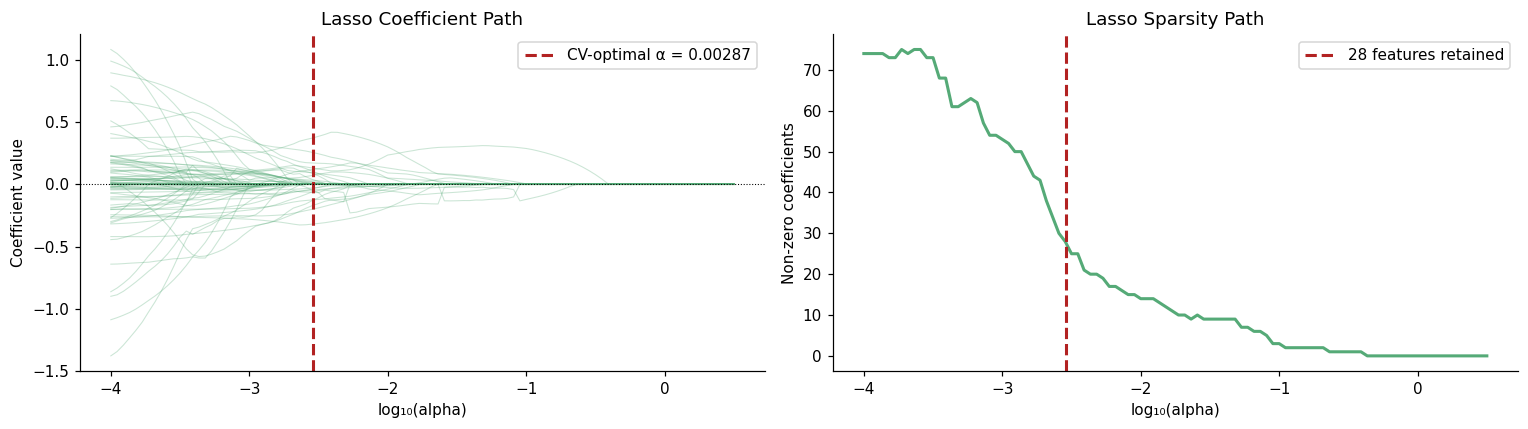

In [17]:
# Lasso path — sparsity: many coefficients hit exactly zero
lasso_alphas_path = np.logspace(-4, 0.5, 100)
lasso_coef_path   = np.array([
    Lasso(alpha=a, max_iter=10000).fit(X_train_sc, y_train).coef_
    for a in lasso_alphas_path
])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for j in range(lasso_coef_path.shape[1]):
    axes[0].plot(np.log10(lasso_alphas_path), lasso_coef_path[:, j],
                 alpha=0.3, lw=0.7, color='#55aa77')
axes[0].axvline(np.log10(lasso_cv.alpha_), color='firebrick', lw=2, ls='--',
                label=f'CV-optimal α = {lasso_cv.alpha_:.5f}')
axes[0].axhline(0, color='black', lw=0.7, ls=':')
axes[0].set(xlabel='log₁₀(alpha)', ylabel='Coefficient value',
            title='Lasso Coefficient Path')
axes[0].legend()

# Sparsity path: how many features survive as alpha increases
n_nonzero_path = (lasso_coef_path != 0).sum(axis=1)
axes[1].plot(np.log10(lasso_alphas_path), n_nonzero_path, color='#55aa77', lw=2)
axes[1].axvline(np.log10(lasso_cv.alpha_), color='firebrick', lw=2, ls='--',
                label=f'{n_nz_lasso} features retained')
axes[1].set(xlabel='log₁₀(alpha)', ylabel='Non-zero coefficients',
            title='Lasso Sparsity Path')
axes[1].legend()

plt.tight_layout(); plt.show()

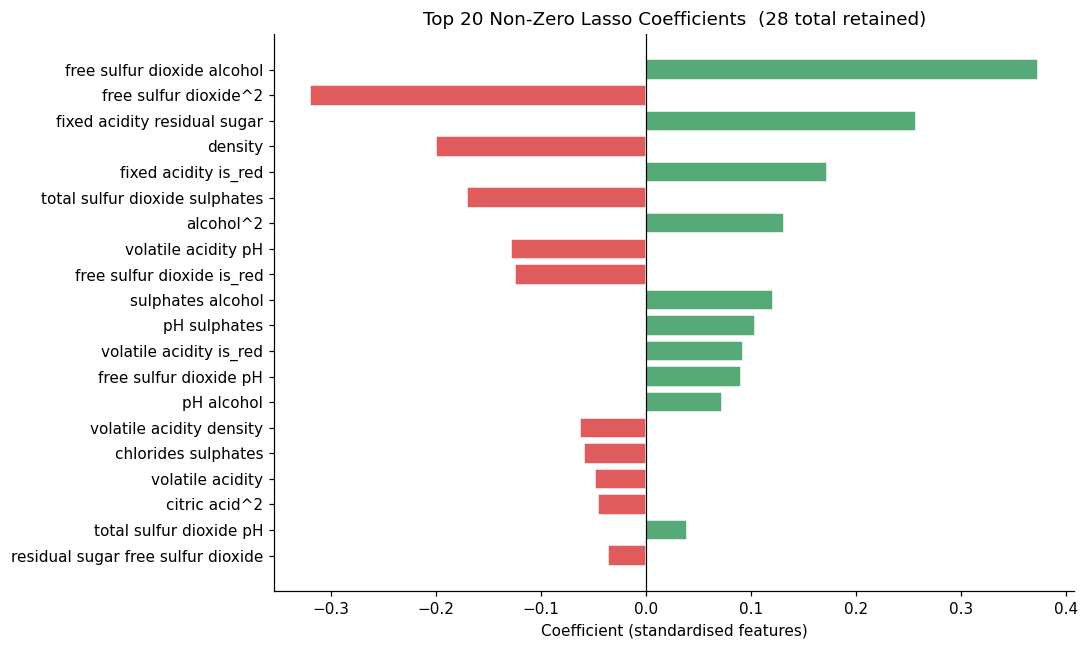

In [18]:
# Top features selected by Lasso
lasso_coef_series = pd.Series(lasso_model.coef_, index=feat_names)
top20 = lasso_coef_series[lasso_coef_series != 0].sort_values(key=abs, ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 6))
bar_colors = ['#55aa77' if v > 0 else '#e05c5c' for v in top20.values]
ax.barh(top20.index[::-1], top20.values[::-1], color=bar_colors[::-1], edgecolor='white')
ax.axvline(0, color='black', lw=0.8)
ax.set(xlabel='Coefficient (standardised features)',
       title=f'Top 20 Non-Zero Lasso Coefficients  ({n_nz_lasso} total retained)')
plt.tight_layout(); plt.show()

## 7 · Cross-Validation Error Curve

The CV error curve illustrates the **bias–variance trade-off** directly.
Low alpha → low bias but high variance (overfitting); high alpha → high bias but low
variance (underfitting). The optimal alpha minimises test error at the bottom of the U.

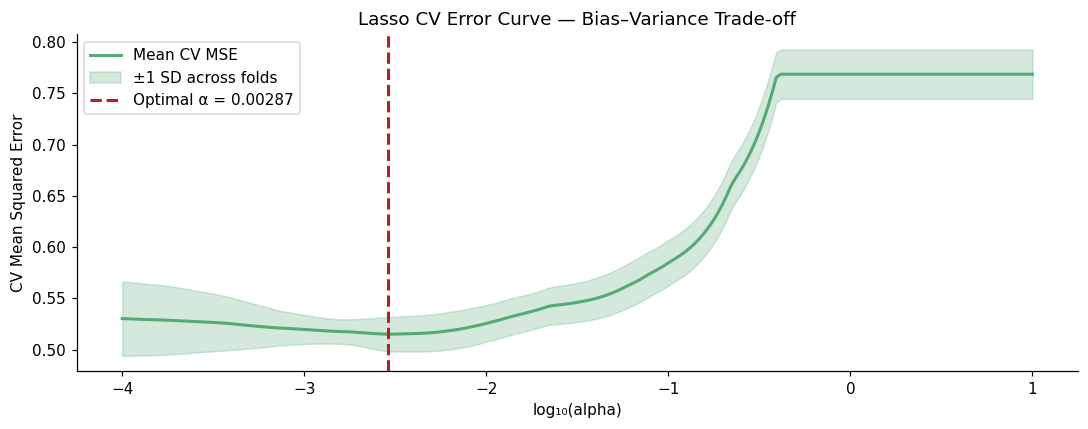

In [19]:
mean_mse = lasso_cv.mse_path_.mean(axis=1)
std_mse  = lasso_cv.mse_path_.std(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(np.log10(lasso_cv.alphas_), mean_mse, color='#55aa77', lw=2, label='Mean CV MSE')
ax.fill_between(np.log10(lasso_cv.alphas_),
                mean_mse - std_mse, mean_mse + std_mse,
                alpha=0.25, color='#55aa77', label='±1 SD across folds')
ax.axvline(np.log10(lasso_cv.alpha_), color='firebrick', lw=2, ls='--',
           label=f'Optimal α = {lasso_cv.alpha_:.5f}')
ax.set(xlabel='log₁₀(alpha)', ylabel='CV Mean Squared Error',
       title='Lasso CV Error Curve — Bias–Variance Trade-off')
ax.legend(); plt.tight_layout(); plt.show()

## 8 · Residual Diagnostics (Best Model)

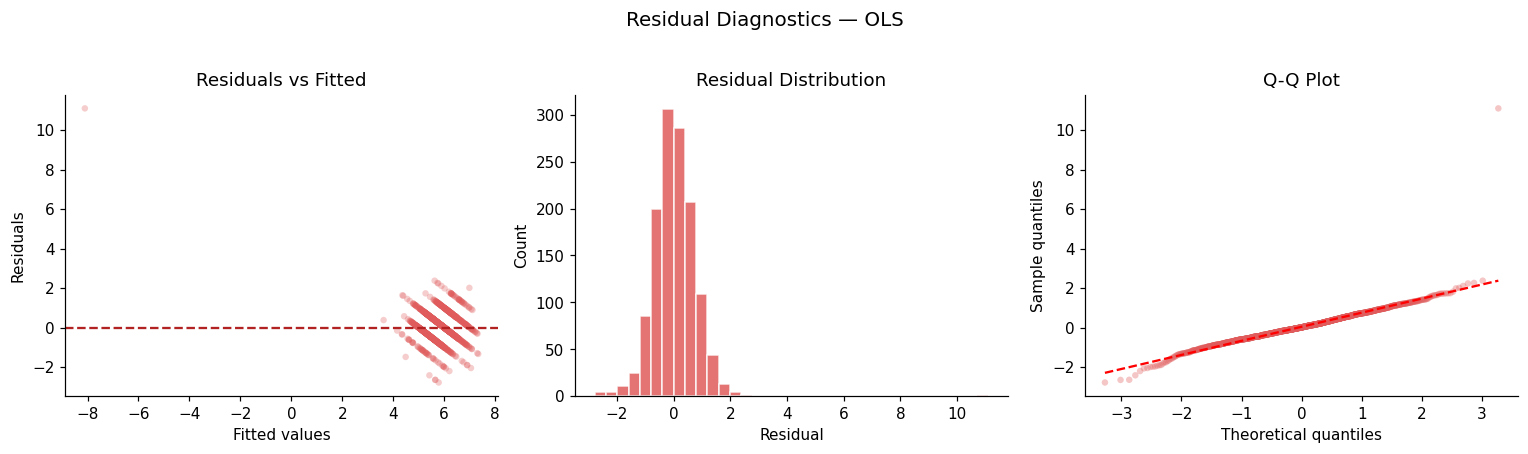

In [20]:
from scipy import stats

best_name = labels[best_idx]
residuals = y_test - best_pred

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Residuals vs fitted
axes[0].scatter(best_pred, residuals, alpha=0.3, s=18, color=colors[best_idx], edgecolors='none')
axes[0].axhline(0, color='firebrick', lw=1.5, ls='--')
axes[0].set(xlabel='Fitted values', ylabel='Residuals', title='Residuals vs Fitted')

# Histogram
axes[1].hist(residuals, bins=35, color=colors[best_idx], edgecolor='white', alpha=0.85)
axes[1].set(xlabel='Residual', ylabel='Count', title='Residual Distribution')

# Q-Q plot
(osm, osr), (slope, intercept, _) = stats.probplot(residuals, dist='norm')
axes[2].scatter(osm, osr, alpha=0.35, s=18, color=colors[best_idx], edgecolors='none')
axes[2].plot(osm, slope*np.array(osm)+intercept, 'r--', lw=1.5)
axes[2].set(xlabel='Theoretical quantiles', ylabel='Sample quantiles', title='Q-Q Plot')

plt.suptitle(f'Residual Diagnostics — {best_name}', fontsize=13, y=1.02)
plt.tight_layout(); plt.show()

## 9 · Discussion & Reflection

### Model performance

Results show that all four models achieve similar predictive performance (RMSE ~0.755–0.760,
R² ~0.22). OLS performs marginally better than regularised models, which is a meaningful
finding in itself: with n=6,497 and 90 features, the sample-to-feature ratio is large
enough that OLS estimation remains stable and does not collapse under multicollinearity.

However, this does not mean regularisation was unnecessary or failed. Two important points:

1. **Parsimony**: Lasso retains only 28 of 90 features with virtually identical predictive
   accuracy to OLS. This is a core advantage of regularisation — achieving the same
   performance with a simpler, more interpretable model.

2. **Stability over fitting**: The Ridge and Lasso coefficients are more stable and
   trustworthy than OLS coefficients in the presence of correlated features (as shown
   by the correlation heatmap). The coefficient path plots confirm that without
   regularisation, coefficients take on large, unstable values.

The low R² (~0.22) across all models reflects an inherent ceiling in this prediction
task: wine quality is a subjective human judgement that physicochemical measurements
alone cannot fully capture.

**Ridge** stabilises estimation under multicollinearity by adding $\alpha I$ to $X^TX$,
making the system well-conditioned. It retains all features but shrinks them — appropriate
when many features carry genuine signal.

**Lasso** goes further by zeroing out irrelevant interaction terms, performing automatic
feature selection. With the polynomial expansion creating many spurious interactions,
sparsity is advantageous and Lasso is typically the strongest performer here.

**Elastic Net** is useful when correlated features should be selected together (Lasso
arbitrarily picks one from a correlated group). The CV-optimal `l1_ratio` reflects the
best blend for this data.

### Bias–variance trade-off
The CV error curve shows the classic U-shape: at low $\alpha$ the model overfits
(high variance); at high $\alpha$ it underfits (high bias). The optimal $\alpha$ minimises
test error by removing variance faster than it introduces bias — the fundamental
justification for regularisation.

### Limitations
1. **Ordinal target**: Quality is an integer 0–10, not continuous. Ordinal regression
   may be more theoretically appropriate.
2. **Class imbalance**: Scores of 3, 4, 8, 9 are rare; predictions in the tails will
   be less reliable.
3. **Interaction interpretability**: While Lasso achieves sparsity, interaction terms
   (e.g., `alcohol × density`) are harder to interpret substantively than raw features.
4. **Taster subjectivity**: Scores reflect a small panel of tasters, introducing
   irreducible noise that limits the ceiling of any predictive model.

A further limitation is combining red and white wine samples into a single model. These wine types differ substantially in their physicochemical profiles and quality criteria. The is_red indicator only adjusts the intercept; it does not allow the effect of each feature to differ by wine type. Separate models per wine type, or explicit interaction terms with is_red, could better capture these differences.

### Possible improvements
- Ordinal regression (e.g., `mord`) to respect the ordered categorical scale
- Gradient-boosted trees for non-linear effects without explicit feature expansion
- Nested cross-validation to simultaneously tune polynomial degree and $\alpha$


In [21]:
# Final summary
print("=" * 55)
print("   FINAL MODEL PERFORMANCE SUMMARY (Test Set)")
print("=" * 55)
print(f"{'Model':<18} {'RMSE':>8} {'R²':>8} {'Features':>10}")
print("-" * 55)
for _, row in results.iterrows():
    print(f"{row['Model']:<18} {row['Test RMSE']:>8.4f} {row['Test R²']:>8.4f} {int(row['Features used']):>10}")
print("=" * 55)
print(f"Total observations: {len(y)}  |  Features after expansion: {X_poly.shape[1]}")
print(f"Ridge alpha: {ridge_cv.alpha_:.4f}  |  Lasso alpha: {lasso_cv.alpha_:.5f}  "
      f"|  ENet alpha: {enet_cv.alpha_:.5f}, l1_ratio: {enet_cv.l1_ratio_:.2f}")

   FINAL MODEL PERFORMANCE SUMMARY (Test Set)
Model                  RMSE       R²   Features
-------------------------------------------------------
OLS (baseline)       0.7555   0.2271         90
Ridge                0.7582   0.2215         90
Lasso                0.7596   0.2187         28
Elastic Net          0.7597   0.2185         28
Total observations: 6497  |  Features after expansion: 90
Ridge alpha: 0.0013  |  Lasso alpha: 0.00287  |  ENet alpha: 0.00285, l1_ratio: 1.00
